In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/swinirkrtik/001_classicalSR_DF2K_s64w8_SwinIR-M_x4.pth
/kaggle/input/alphacoders/blur_dataset/sharp_Image/641.png
/kaggle/input/alphacoders/blur_dataset/sharp_Image/173.png
/kaggle/input/alphacoders/blur_dataset/sharp_Image/491.png
/kaggle/input/alphacoders/blur_dataset/sharp_Image/043.png
/kaggle/input/alphacoders/blur_dataset/sharp_Image/379.png
/kaggle/input/alphacoders/blur_dataset/sharp_Image/248.png
/kaggle/input/alphacoders/blur_dataset/sharp_Image/038.png
/kaggle/input/alphacoders/blur_dataset/sharp_Image/069.png
/kaggle/input/alphacoders/blur_dataset/sharp_Image/480.png
/kaggle/input/alphacoders/blur_dataset/sharp_Image/236.png
/kaggle/input/alphacoders/blur_dataset/sharp_Image/675.png
/kaggle/input/alphacoders/blur_dataset/sharp_Image/340.png
/kaggle/input/alphacoders/blur_dataset/sharp_Image/083.png
/kaggle/input/alphacoders/blur_dataset/sharp_Image/513.png
/kaggle/input/alphacoders/blur_dataset/sharp_Image/677.png
/kaggle/input/alphacoders/blur_dataset/sharp_I

In [3]:
model_path = '/kaggle/input/your-swinir-weights-folder/001_classicalSR_DIV2K_s48w8_SwinIR-M_x4.pth'

In [4]:
blur_path = "/kaggle/input/alphacoders/blur_dataset/blur_Image"
sharp_path = "/kaggle/input/alphacoders/blur_dataset/sharp_Image"
model_path = "/kaggle/input/swinirrtik/001_classicalSR_DF2K_s64w8_SwinIR-M_x4.pth"


In [5]:
!git clone https://github.com/JingyunLiang/SwinIR.git
%cd SwinIR


Cloning into 'SwinIR'...
remote: Enumerating objects: 333, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 333 (delta 6), reused 2 (delta 2), pack-reused 323 (from 2)
Receiving objects: 100% (333/333), 29.84 MiB | 40.74 MiB/s, done.
Resolving deltas: 100% (119/119), done.
/kaggle/working/SwinIR


In [6]:
!pip install timm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-

In [7]:
!pip install torch torchvision timm scikit-image



In [8]:
from torch.utils.data import Dataset
from PIL import Image
import os
from torchvision import transforms

class BlurSharpDataset(Dataset):
    def __init__(self, blur_dir, sharp_dir, transform=None):
        self.blur_dir = blur_dir
        self.sharp_dir = sharp_dir
        self.transform = transform
        self.image_names = sorted(os.listdir(blur_dir))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        blur_image = Image.open(os.path.join(self.blur_dir, self.image_names[idx]))
        sharp_image = Image.open(os.path.join(self.sharp_dir, self.image_names[idx]))
        
        if self.transform:
            blur_image = self.transform(blur_image)
            sharp_image = self.transform(sharp_image)
        return blur_image, sharp_image


In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Create Dataset
train_dataset = BlurSharpDataset(
    '/kaggle/input/alphacoders/blur_dataset/blur_Image',
    '/kaggle/input/alphacoders/blur_dataset/sharp_Image',
    transform=transform
)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)


In [14]:
# Install timm if not done (Kaggle default usually has it)
# !pip install timm

# Imports
import torch
from models.network_swinir import SwinIR

# Define the Teacher model — matching SwinIR-M config for Super-Resolution
teacher_model = SwinIR(
    upscale=4,                    # x4 SR model
    in_chans=3,                   # RGB images
    img_size=64,                  # patch size 64
    window_size=8,                # window size 8
    img_range=1.0,                # image values 0-1
    depths=[6,6,6,6,6,6],         # 6 residual groups
    embed_dim=180,                # embed dimension as per SwinIR-M
    num_heads=[6,6,6,6,6,6],      # 6 heads
    mlp_ratio=2.0,                # default MLP ratio
    upsampler='pixelshuffle',     # important for SR model (adds upsampling blocks)
    resi_connection='1conv'       # default residual connection
)

# Load pretrained checkpoint
checkpoint = torch.load('/kaggle/input/swinirkrtik/001_classicalSR_DF2K_s64w8_SwinIR-M_x4.pth')

# Load state_dict safely from 'params' key
teacher_model.load_state_dict(checkpoint['params'])

# Set model to eval mode and move to GPU
teacher_model.eval().cuda()

# Confirm loaded
print("✅ SwinIR-M pretrained teacher model loaded successfully on GPU.")


✅ SwinIR-M pretrained teacher model loaded successfully on GPU.


In [15]:
import torch.nn as nn

# Define a simple Student CNN for sharpening
class StudentCNN(nn.Module):
    def __init__(self):
        super(StudentCNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(64, 3, 3, 1, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Initialize student model and move to GPU
student_model = StudentCNN().cuda()
print("✅ Student model initialized.")


✅ Student model initialized.


In [17]:
import torch.optim as optim

# Loss functions
criterion_l1 = nn.L1Loss()

# Optimizer
optimizer = optim.Adam(student_model.parameters(), lr=1e-4)


In [19]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

# Student CNN Model
class StudentCNN(nn.Module):
    def __init__(self):
        super(StudentCNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(64, 3, 3, 1, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Initialize student model
student_model = StudentCNN().cuda()

# Loss + Optimizer
criterion_l1 = nn.L1Loss()
optimizer = optim.Adam(student_model.parameters(), lr=1e-4)

# Training Loop
epochs = 5
for epoch in range(epochs):
    student_model.train()
    running_loss = 0.0

    for blur_img, sharp_img in train_loader:
        blur_img, sharp_img = blur_img.cuda(), sharp_img.cuda()

        # Teacher inference (no grad)
        with torch.no_grad():
            teacher_output = teacher_model(blur_img)
        
        # Resize teacher output to 256x256
        teacher_output_resized = F.interpolate(teacher_output, size=(256, 256), mode='bilinear', align_corners=False)

        # Student inference
        student_output = student_model(blur_img)

        # Loss: L1 between student and sharp image + KD loss
        loss_l1 = criterion_l1(student_output, sharp_img)
        kd_loss = criterion_l1(student_output, teacher_output_resized)

        total_loss = loss_l1 + 0.5 * kd_loss

        # Backward and optimize
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("✅ Training complete.")


Epoch [1/5], Loss: 0.2076
Epoch [2/5], Loss: 0.0339
Epoch [3/5], Loss: 0.0227
Epoch [4/5], Loss: 0.0199
Epoch [5/5], Loss: 0.0183
✅ Training complete.


In [23]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
import torch

# ✅ SSIM function (modern safe version)
def calculate_ssim(img1, img2):
    img1 = torch.clamp(img1, 0, 1).detach().cpu().numpy().transpose(1, 2, 0)
    img2 = torch.clamp(img2, 0, 1).detach().cpu().numpy().transpose(1, 2, 0)
    return ssim(img1, img2, data_range=1.0, channel_axis=-1)

# ✅ Evaluate SSIM on one example
student_model.eval()
with torch.no_grad():
    for blur_img, sharp_img in train_loader:
        blur_img, sharp_img = blur_img.cuda(), sharp_img.cuda()
        output = student_model(blur_img)

        ssim_value = calculate_ssim(output[0], sharp_img[0])
        print(f"✅ SSIM between student output and sharp image: {ssim_value:.4f}")
        break


✅ SSIM between student output and sharp image: 0.9530


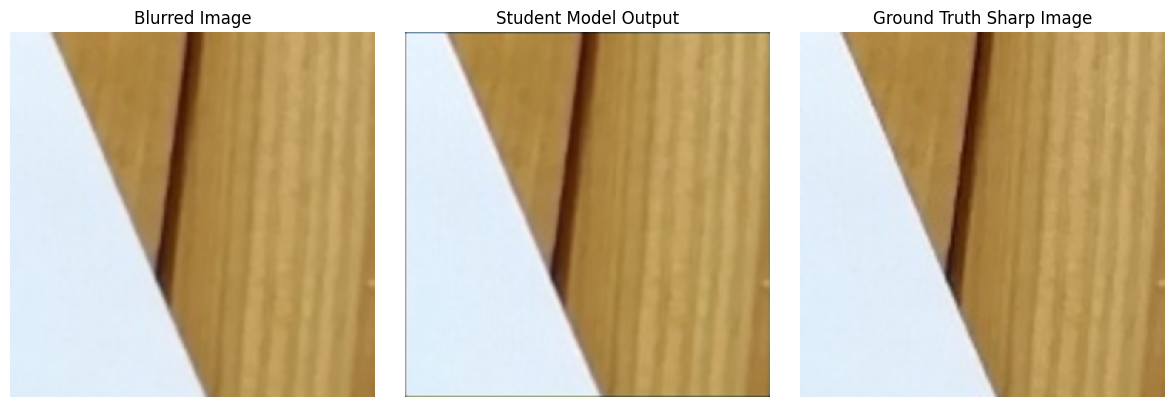

In [26]:
import matplotlib.pyplot as plt
import torch

# ✅ Function to display images
def show_image(tensor, title):
    img = torch.clamp(tensor, 0, 1).detach().cpu().numpy().transpose(1, 2, 0)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# ✅ Display one sample: Blur Image | Sharp Image | Student Output
student_model.eval()
with torch.no_grad():
    for blur_img, sharp_img in train_loader:
        blur_img, sharp_img = blur_img.cuda(), sharp_img.cuda()
        output = student_model(blur_img)

        # Plotting side by side
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        show_image(blur_img[0], "Blurred Image")

        plt.subplot(1, 3, 2)
        show_image(output[0], "Student Model Output")

        plt.subplot(1, 3, 3)
        show_image(sharp_img[0], "Ground Truth Sharp Image")

        plt.tight_layout()
        plt.show()
        break


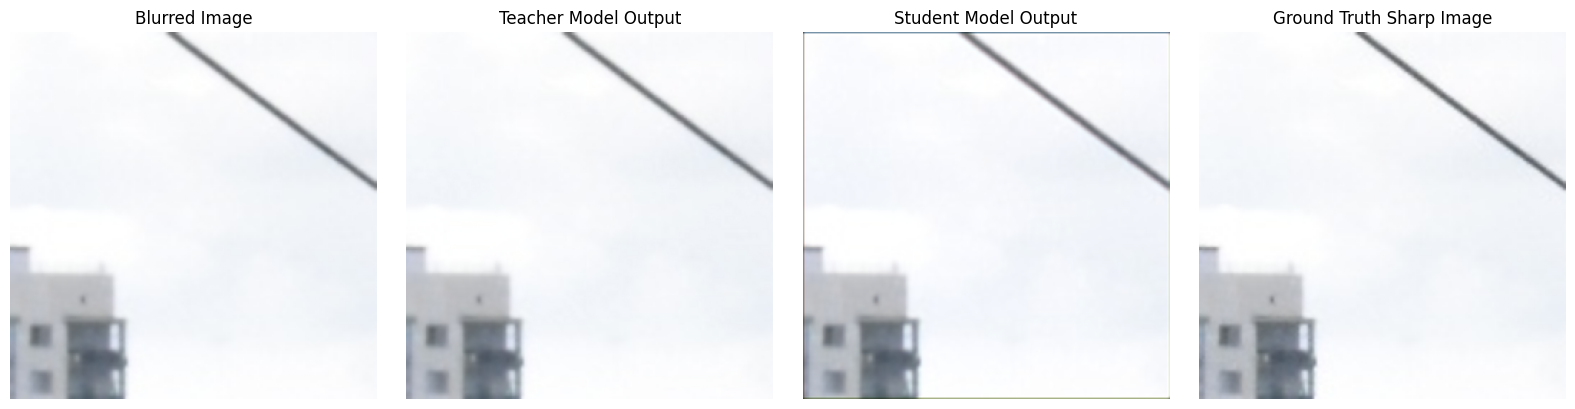

In [28]:
import matplotlib.pyplot as plt
import torch

# ✅ Function to display images
def show_image(tensor, title):
    img = torch.clamp(tensor, 0, 1).detach().cpu().numpy().transpose(1, 2, 0)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# ✅ Show one example: Blur Image | Teacher Output | Student Output | Sharp Ground Truth
teacher_model.eval()
student_model.eval()
with torch.no_grad():
    for blur_img, sharp_img in train_loader:
        blur_img, sharp_img = blur_img.cuda(), sharp_img.cuda()

        # Teacher model output (resize to 256x256 to match others)
        teacher_output = teacher_model(blur_img)
        teacher_output_resized = F.interpolate(teacher_output, size=(256, 256), mode='bilinear', align_corners=False)

        # Student model output
        student_output = student_model(blur_img)

        # Plotting side by side
        plt.figure(figsize=(16, 4))

        plt.subplot(1, 4, 1)
        show_image(blur_img[0], "Blurred Image")

        plt.subplot(1, 4, 2)
        show_image(teacher_output_resized[0], "Teacher Model Output")

        plt.subplot(1, 4, 3)
        show_image(student_output[0], "Student Model Output")

        plt.subplot(1, 4, 4)
        show_image(sharp_img[0], "Ground Truth Sharp Image")

        plt.tight_layout()
        plt.show()
        break


In [29]:
plt.savefig('/kaggle/working/comparison_output.png')


<Figure size 640x480 with 0 Axes>

In [31]:
torch.save(student_model.state_dict(), '/kaggle/working/student_model_sharpening.pth')
print("✅ Student model saved.")


✅ Student model saved.
